In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 5, 'capthick': 2, 'elinewidth': 2, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

# Color palate with basal, default, and perturbation colors
colors_basal = ['whitesmoke','lightsteelblue', 'steelblue']

# Color palate default, perturbation
colors_default = ['lightsteelblue', 'steelblue']

# Colors to highlight metabolites
# Glucose, lactate, 3HB, Fatty acids
colors_met = ['firebrick', 'lightcoral', 'wheat', 'gold']

In [2]:
df = pd.read_csv('./data/co2.csv')
df.columns = df.columns.str.upper()

# Get cage to tracer meta data
metda_data = df.groupby(['CAGE', 'DAY','TRACER', 'TRACER_UMOL_MIN']).size().reset_index(name='COUNTS')  

# Curate data 
# Change Day entries from 2/3 to non-perturbative / perturbative
df['DAY'] = df['DAY'].apply(lambda x: 'non-perturbative' if x == 2 else 'perturbative')
df.head()


,DAY,TIME,VCO2,SI13C,TRACER,CAGE,ENRICH,TRACER_UMOL_MIN,CO2_FLUX,RECOVERY
0,non-perturbative,-352,1.249430,-11.785750,glucose,1,-0.000107,2.04120,-0.005979,-0.003255
1,non-perturbative,-356,1.696254,-10.642560,lactate,2,-0.000095,1.56240,-0.007166,-0.005096
2,non-perturbative,-362,1.689503,-8.962937,3hb,3,-0.000076,0.40160,-0.005745,-0.015896
3,non-perturbative,-367,1.515335,-5.852248,glucose,4,-0.000042,2.17560,-0.002840,-0.001451
4,non-perturbative,-373,2.085561,-8.653533,lactate,5,-0.000073,1.81629,-0.006776,-0.004145


In [3]:
# Load serum labeling data 
df2 = pd.read_csv('./data/perturbative_experiments_labeling_combined_240804.csv')
df2.columns = df2.columns.str.upper()
df2 = df2.melt(id_vars=['COMPOUND', 'C_LABEL'])

# Fetch data from variable column
# Day1_Cage2_T0 -> Day = 1 , Cage = 2, Time = 0
df2['DAY'] = df2['variable'].apply(lambda x: int(x.split('_')[0][3:])) + 1
df2['CAGE'] = df2['variable'].apply(lambda x: int(x.split('_')[1][4:]))
df2['TIME'] = df2['variable'].apply(lambda x: int(x.split('_')[2][1:]))

# Integate metadata based on cage and day
df2 = pd.merge(df2, metda_data, on=['CAGE', 'DAY'])

df2['DAY'] = df2['DAY'].apply(lambda x: 'non-perturbative' if x == 2 else 'perturbative')

df2.head()

,COMPOUND,C_LABEL,variable,value,DAY,CAGE,TIME,TRACER,TRACER_UMOL_MIN,COUNTS
0,lactate,0,DAY1_CAGE2_T0,0.999246,non-perturbative,2,0,lactate,1.5624,1449
1,lactate,1,DAY1_CAGE2_T0,0.000599,non-perturbative,2,0,lactate,1.5624,1449
2,lactate,2,DAY1_CAGE2_T0,0.000071,non-perturbative,2,0,lactate,1.5624,1449
3,lactate,3,DAY1_CAGE2_T0,0.000083,non-perturbative,2,0,lactate,1.5624,1449
4,Glucose,0,DAY1_CAGE2_T0,0.998108,non-perturbative,2,0,lactate,1.5624,1449


In [4]:
# Load serum metabolomics data
df3 = pd.read_csv('./data/perturbative_experiments_pool_size_combined_240804.csv')
df3.columns = df3.columns.str.upper()

# Substract blank values from data
blank = df3['Blank_before_plasma_2'.upper()]
df3 = df3.drop(columns=['Blank_before_plasma_2'.upper()])
df3.iloc[:,1:] = df3.iloc[:,1:].sub(blank, axis=0)

df3 = df3.melt(id_vars=['COMPOUND'])
# Fetch data from variable column
# Day1_Cage2_T0 -> Day = 1 , Cage = 2, Time = 0
df3['DAY'] = df3['variable'].apply(lambda x: int(x.split('_')[0][3:])) + 1
df3['CAGE'] = df3['variable'].apply(lambda x: int(x.split('_')[1][4:]))
df3['TIME'] = df3['variable'].apply(lambda x: int(x.split('_')[2][1:]))

# Integate metadata based on cage and day
df3 = pd.merge(df3, metda_data, on=['CAGE', 'DAY'])

# Normalize data to mean of T0
mean = df3[df3['TIME'] == 0].groupby(['TRACER','DAY','COMPOUND'])['value'].mean().reset_index(name='MEAN_T0')
df3 = pd.merge(df3, mean, on=['TRACER','DAY','COMPOUND'])

df3['value_normalized'] = df3['value'] / df3['MEAN_T0']


df3['DAY'] = df3['DAY'].apply(lambda x: 'non-perturbative' if x == 2 else 'perturbative')

df3.head()


,COMPOUND,variable,value,DAY,CAGE,TIME,TRACER,TRACER_UMOL_MIN,COUNTS,MEAN_T0,value_normalized
0,3-hydroxybutyrate,DAY1_CAGE3_T0,1.515275e+07,non-perturbative,3,0,3hb,0.4016,1449,1.267486e+07,1.195497
1,3-hydroxybutyrate,DAY1_CAGE3_T60,1.812762e+07,non-perturbative,3,60,3hb,0.4016,1449,1.267486e+07,1.430203
2,3-hydroxybutyrate,DAY1_CAGE3_T120,1.645896e+07,non-perturbative,3,120,3hb,0.4016,1449,1.267486e+07,1.298551
3,3-hydroxybutyrate,DAY1_CAGE3_T150,1.506627e+07,non-perturbative,3,150,3hb,0.4016,1449,1.267486e+07,1.188673
4,3-hydroxybutyrate,DAY1_CAGE6_T0,1.209092e+07,non-perturbative,6,0,3hb,0.4320,1449,1.267486e+07,0.953929


In [5]:
# Import stats
from scipy import stats

# Plott concentration data for each TRACER and DAY 
def plot_concentration_data(df, tracer, compound, colors = colors_basal, time = 150, folder='output'):
    df = df[(df['TRACER'] == tracer) & (df['COMPOUND'] == compound)]

    basal = df[df['TIME'] == 0]
    basal.loc[:,'condition'] = 'Basal'
    non_perturbative = df[(df['DAY'] == 'non-perturbative') & (df['TIME'] == time)]
    non_perturbative.loc[:,'condition'] = 'Non-perturbative'
    perturbative = df[(df['DAY'] == 'perturbative') & (df['TIME'] == time)]
    perturbative.loc[:,'condition'] = 'Perturbative'
    data = pd.concat([basal, non_perturbative, perturbative])

    plt.figure(figsize=(2.5, 4))

    # Make three bars for each condition basal, non-perturbative, perturbative
    # Add the original data points on top of the bars
    plt.bar(0, basal['value_normalized'].mean(), color=colors[0], label='Basal', 
            edgecolor='black')
    plt.errorbar(0, basal['value_normalized'].mean(), 
                 yerr=basal['value_normalized'].sem(),  color='black',
                 **errorbar_kwargs)

    plt.bar(1, non_perturbative['value_normalized'].mean(), color=colors[1], 
            label='Non-perturbative', edgecolor='black')
    plt.errorbar(1, non_perturbative['value_normalized'].mean(), 
                 yerr=non_perturbative['value_normalized'].sem(),  color='black',
                 **errorbar_kwargs)

    plt.bar(2, perturbative['value_normalized'].mean(), color=colors[2], 
            label='Perturbative', edgecolor='black')
    plt.errorbar(2, perturbative['value_normalized'].mean(), 
                 yerr=perturbative['value_normalized'].sem(),  color='black' ,
                 **errorbar_kwargs)
    
    # Add original data points with jitter
    sns.stripplot(x='condition', y='value_normalized', 
                  data=data, jitter=True, color='dimgrey', alpha=1.0, legend=False)    
    
    # Compute p-values between basal and non-perturbative, basal and perturbative
    p_1 = stats.ttest_ind(basal['value_normalized'], non_perturbative['value_normalized']).pvalue
    p_2 = stats.ttest_ind(basal['value_normalized'], perturbative['value_normalized']).pvalue

    print(f'p-value basal vs non-perturbative: {p_1}')
    print(f'p-value basal vs perturbative: {p_2}')
    
    plt.xlabel('')
    plt.ylabel(f'{compound.capitalize()} \n (relative to basal)')
    plt.xticks([0, 1, 2], ['Basal', 'Non-perturbative', 'Perturbative'], rotation=30, ha='right')
    # Legend on top outside of plot
    # plt.legend(loc='upper center', bbox_to_anchor=(0.75, 1.3), ncol=1)    
    sns.despine()    
    
    filename = f'{tracer}_{compound}_concentration.svg'
    plt.savefig(folder + '/' + filename)

    plt.show()


p-value basal vs non-perturbative: 0.0005513611139505847
p-value basal vs perturbative: 0.00019901234656070034


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3212875013.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basal.loc[:,'condition'] = 'Basal'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3212875013.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_perturbative.loc[:,'condition'] = 'Non-perturbative'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3212875013.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

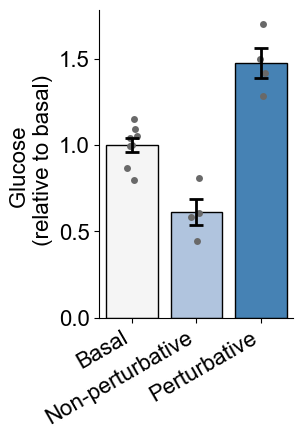

In [6]:
plot_concentration_data(df3, 'glucose', 'Glucose')

p-value basal vs non-perturbative: 4.6977349218166926e-07
p-value basal vs perturbative: 0.5199787281780242


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3212875013.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basal.loc[:,'condition'] = 'Basal'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3212875013.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_perturbative.loc[:,'condition'] = 'Non-perturbative'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3212875013.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

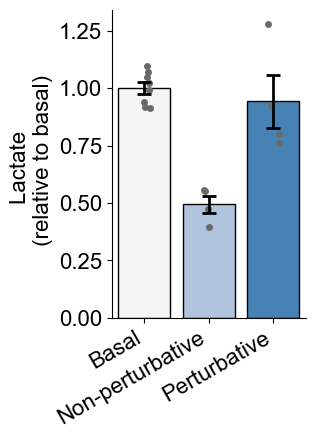

In [45]:
plot_concentration_data(df3, 'glucose', 'lactate')

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3212875013.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basal.loc[:,'condition'] = 'Basal'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3212875013.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_perturbative.loc[:,'condition'] = 'Non-perturbative'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3212875013.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

p-value basal vs non-perturbative: 0.004990614999383727
p-value basal vs perturbative: 9.111332422989688e-05


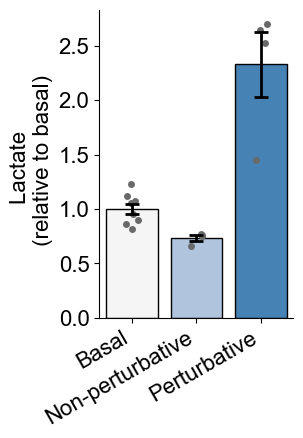

In [7]:
plot_concentration_data(df3, 'lactate', 'lactate')

p-value basal vs non-perturbative: 0.1678915826516914
p-value basal vs perturbative: 0.0004221496005386782


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3212875013.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basal.loc[:,'condition'] = 'Basal'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3212875013.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_perturbative.loc[:,'condition'] = 'Non-perturbative'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3212875013.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

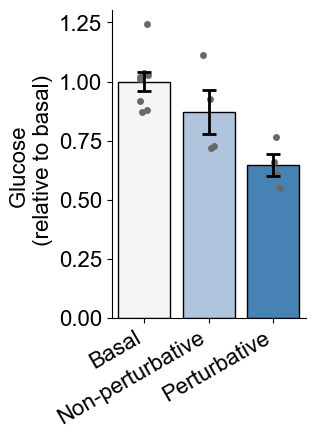

In [46]:
plot_concentration_data(df3, 'lactate', 'Glucose')

p-value basal vs non-perturbative: 0.01580437247365839
p-value basal vs perturbative: 0.0001335886903293517


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3212875013.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basal.loc[:,'condition'] = 'Basal'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3212875013.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_perturbative.loc[:,'condition'] = 'Non-perturbative'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3212875013.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

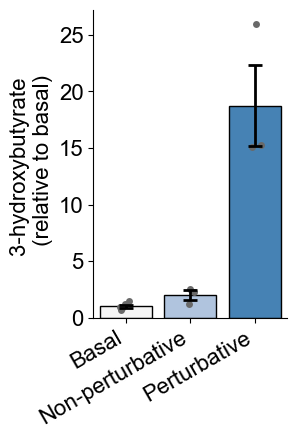

In [8]:
plot_concentration_data(df3, '3hb', '3-hydroxybutyrate')

In [9]:
# Plot Enrichment data for each TRACER and DAY

def plot_enrichment_data(df, tracer, compound, c_label, colors = colors_basal, time = 150, folder='output'):
    df = df[(df['TRACER'] == tracer) & (df['COMPOUND'] == compound) & (df['C_LABEL'] == c_label)]   

    non_perturbative = df[(df['DAY'] == 'non-perturbative') & (df['TIME'] == time)]
    non_perturbative.loc[:,'condition'] = 'Non-perturbative'

    perturbative = df[(df['DAY'] == 'perturbative') & (df['TIME'] == time)]
    perturbative.loc[:,'condition'] = 'Perturbative'

    data = pd.concat([non_perturbative, perturbative])

    plt.figure(figsize=(2.0, 4))

    # Make two bars for each condition non-perturbative, perturbative
    # Add the original data points on top of the bars

    plt.bar(0, non_perturbative['value'].mean(), color=colors[1],
            label='Non-perturbative', edgecolor='black')
    
    plt.errorbar(0, non_perturbative['value'].mean(),
                    yerr=non_perturbative['value'].sem(), color='black',
                    **errorbar_kwargs)
    

    plt.bar(1, perturbative['value'].mean(), color=colors[2],
            label='Perturbative', edgecolor='black')
    
    plt.errorbar(1, perturbative['value'].mean(),
                    yerr=perturbative['value'].sem(), color='black',
                    **errorbar_kwargs)
    
    # Add original data points with jitter
    sns.stripplot(x='condition', y='value', 
                  data=data, jitter=True, color='dimgrey', alpha=1.0, legend=False)
    
    # Compute p-values between non-perturbative and perturbative
    p = stats.ttest_ind(non_perturbative['value'], perturbative['value']).pvalue
    print(f'p-value non-perturbative vs perturbative: {p}')

    plt.xlabel('')
    plt.ylabel(f'{compound.capitalize()} \n (fraction labeled)')
    plt.xticks([0, 1], ['Non-perturbative', 'Perturbative'], rotation=30, ha='right')
    # Legend on top outside of plot
    # plt.legend(loc='upper center', bbox_to_anchor=(0.75, 1.3), ncol=1)
    plt.ylim([0,1])
    sns.despine()

    filename = f'{tracer}_{compound}_{c_label}_enrichment.svg'
    plt.savefig(folder + '/' + filename)

    plt.show()



/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/4233987303.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_perturbative.loc[:,'condition'] = 'Non-perturbative'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/4233987303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbative.loc[:,'condition'] = 'Perturbative'


p-value non-perturbative vs perturbative: 4.738396359813365e-08


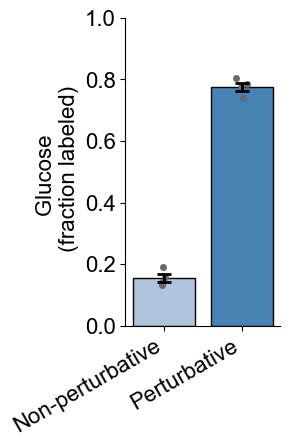

In [10]:
plot_enrichment_data(df2, 'glucose', 'Glucose', 6)

p-value non-perturbative vs perturbative: 2.2460125623426997e-05


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/4233987303.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_perturbative.loc[:,'condition'] = 'Non-perturbative'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/4233987303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbative.loc[:,'condition'] = 'Perturbative'


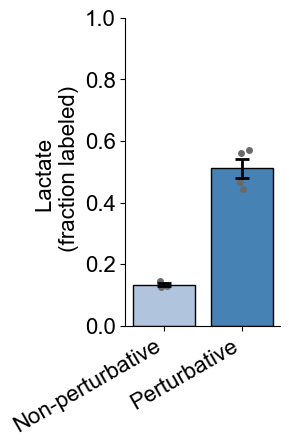

In [11]:
plot_enrichment_data(df2, 'lactate', 'lactate', 3)

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/4233987303.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_perturbative.loc[:,'condition'] = 'Non-perturbative'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/4233987303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbative.loc[:,'condition'] = 'Perturbative'


p-value non-perturbative vs perturbative: 2.062107580502837e-05


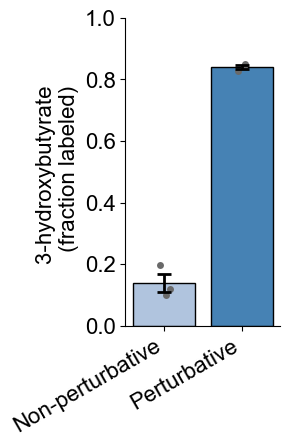

In [12]:
plot_enrichment_data(df2, '3hb', '3-hydroxybutyrate', 4)

In [13]:
def plot_rate_of_appearance(df, tracer, compound, c_label, colors = colors_basal, time = 150, ylim=[0,50], folder='output'):
    # Filter data
    df = df[(df['TRACER'] == tracer) & (df['COMPOUND'] == compound) & (df['C_LABEL'] == c_label)]
    # Compute rate of appearance
    df['rate_of_appearance'] = (1-df['value'])/df['value'] * df['TRACER_UMOL_MIN']

    non_perturbative = df[(df['DAY'] == 'non-perturbative') & (df['TIME'] == time)]
    non_perturbative.loc[:,'condition'] = 'Non-perturbative'

    perturbative = df[(df['DAY'] == 'perturbative') & (df['TIME'] == time)]
    perturbative.loc[:,'condition'] = 'Perturbative'

    data = pd.concat([non_perturbative, perturbative])

    plt.figure(figsize=(2.0, 4))

    # Make two bars for each condition non-perturbative, perturbative
    # Add the original data points on top of the bars

    plt.bar(0, non_perturbative['rate_of_appearance'].mean(), color=colors[1],
            label='Non-perturbative', edgecolor='black')    
    plt.errorbar(0, non_perturbative['rate_of_appearance'].mean(),
                    yerr=non_perturbative['rate_of_appearance'].sem(), color='black',
                    **errorbar_kwargs)


    plt.bar(1, perturbative['rate_of_appearance'].mean(), color=colors[2],
            label='Perturbative', edgecolor='black')
    
    plt.errorbar(1, perturbative['rate_of_appearance'].mean(), 
                    yerr=perturbative['rate_of_appearance'].sem(), color='black',
                    **errorbar_kwargs)
    
    # Add original data points with jitter
    sns.stripplot(x='condition', y='rate_of_appearance', 
                  data=data, jitter=True, color='dimgrey', alpha=1.0, legend=False)
    
    # Compute p-values between non-perturbative and perturbative
    p = stats.ttest_ind(non_perturbative['rate_of_appearance'], perturbative['rate_of_appearance']).pvalue
    print(f'p-value non-perturbative vs perturbative: {p}')

    plt.xlabel('')
    plt.ylabel('$R_a$ ($\mathrm{\mu}$molC/min)')

    plt.xticks([0, 1], ['Non-perturbative', 'Perturbative'], rotation=30, ha='right')
    # Legend on top outside of plot
    # plt.legend(loc='upper center', bbox_to_anchor=(0.75, 1.3), ncol=1)
    plt.ylim(ylim)
    sns.despine()

    filename = f'{tracer}_{compound}_{c_label}_rate_of_appearance.svg'
    plt.savefig(folder + '/' + filename)

    plt.show()

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/2116142237.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rate_of_appearance'] = (1-df['value'])/df['value'] * df['TRACER_UMOL_MIN']
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/2116142237.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_perturbative.loc[:,'condition'] = 'Non-perturbative'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/2116142237.py:11: SettingWithCopyWarning: 
A value is t

p-value non-perturbative vs perturbative: 0.014580997376096241


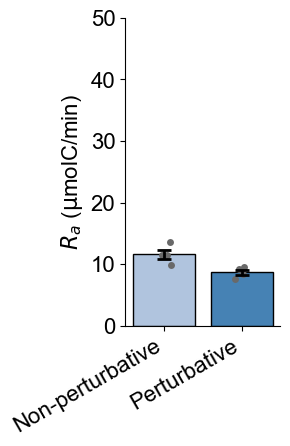

In [14]:
plot_rate_of_appearance(df2, 'glucose', 'Glucose', 6)

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/2116142237.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rate_of_appearance'] = (1-df['value'])/df['value'] * df['TRACER_UMOL_MIN']
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/2116142237.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_perturbative.loc[:,'condition'] = 'Non-perturbative'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/2116142237.py:11: SettingWithCopyWarning: 
A value is t

p-value non-perturbative vs perturbative: 0.37946075571870086


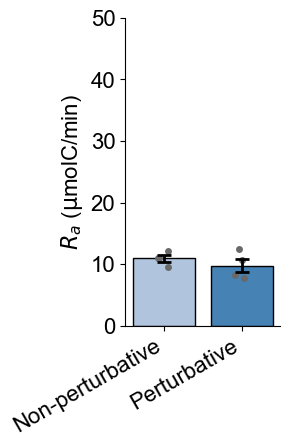

In [15]:
plot_rate_of_appearance(df2, 'lactate', 'lactate', 3)

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/2116142237.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rate_of_appearance'] = (1-df['value'])/df['value'] * df['TRACER_UMOL_MIN']
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/2116142237.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_perturbative.loc[:,'condition'] = 'Non-perturbative'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/2116142237.py:11: SettingWithCopyWarning: 
A value is t

p-value non-perturbative vs perturbative: 0.4808735285660406


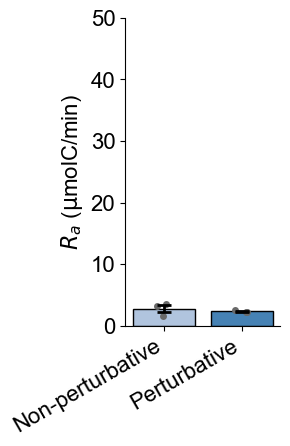

In [16]:
plot_rate_of_appearance(df2, '3hb', '3-hydroxybutyrate', 4)

In [17]:
def plot_rate_of_disappearance(df, tracer, compound, c_label, colors = colors_basal, time = 150, ylim=[0,50], folder='output'):
    # Filter data
    df = df[(df['TRACER'] == tracer) & (df['COMPOUND'] == compound) & (df['C_LABEL'] == c_label)]
    # Compute rate of disappearance
    df['rate_of_disappearance'] = (1-df['value'])/df['value']*df['TRACER_UMOL_MIN'] + df['TRACER_UMOL_MIN'] 

    non_perturbative = df[(df['DAY'] == 'non-perturbative') & (df['TIME'] == time)]
    non_perturbative.loc[:,'condition'] = 'Non-perturbative'

    perturbative = df[(df['DAY'] == 'perturbative') & (df['TIME'] == time)]
    perturbative.loc[:,'condition'] = 'Perturbative'

    data = pd.concat([non_perturbative, perturbative])

    plt.figure(figsize=(2, 4))

    # Make two bars for each condition non-perturbative, perturbative
    # Add the original data points on top of the bars

    plt.bar(0, non_perturbative['rate_of_disappearance'].mean(), color=colors[1],
            label='Non-perturbative', edgecolor='black')    
    plt.errorbar(0, non_perturbative['rate_of_disappearance'].mean(),
                    yerr=non_perturbative['rate_of_disappearance'].sem(), color='black',
                    **errorbar_kwargs)


    plt.bar(1, perturbative['rate_of_disappearance'].mean(), color=colors[2],
            label='Perturbative', edgecolor='black')
    
    plt.errorbar(1, perturbative['rate_of_disappearance'].mean(), 
                    yerr=perturbative['rate_of_disappearance'].sem(), color='black',
                    **errorbar_kwargs)
    
    # Add original data points with jitter
    sns.stripplot(x='condition', y='rate_of_disappearance', 
                  data=data, jitter=True, color='dimgrey', alpha=1.0, legend=False)
    
    # Compute p-values between non-perturbative and perturbative
    p = stats.ttest_ind(non_perturbative['rate_of_disappearance'], perturbative['rate_of_disappearance']).pvalue
    print(f'p-value non-perturbative vs perturbative: {p}')

    plt.xlabel('')
    plt.ylabel('$R_d$ ($\mathrm{\mu}$molC/min)')

    plt.xticks([0, 1], ['Non-perturbative', 'Perturbative'], rotation=30, ha='right')
    # Legend on top outside of plot
    # plt.legend(loc='upper center', bbox_to_anchor=(0.75, 1.3), ncol=1)

    plt.ylim(ylim)
    
    sns.despine()
    
    filename = f'{tracer}_{compound}_{c_label}_rate_of_disappearance.svg'
    plt.savefig(folder + '/' + filename)
    plt.show()


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3284299520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rate_of_disappearance'] = (1-df['value'])/df['value']*df['TRACER_UMOL_MIN'] + df['TRACER_UMOL_MIN']
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3284299520.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_perturbative.loc[:,'condition'] = 'Non-perturbative'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3284299520.py:11: SettingWithC

p-value non-perturbative vs perturbative: 2.3340266508159866e-06


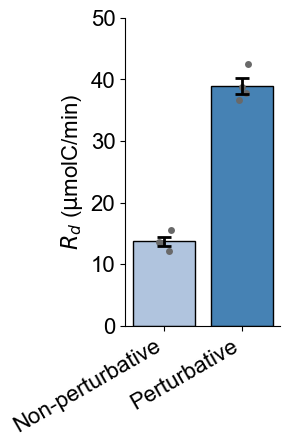

In [18]:
plot_rate_of_disappearance(df2, 'glucose', 'Glucose', 6)

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3284299520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rate_of_disappearance'] = (1-df['value'])/df['value']*df['TRACER_UMOL_MIN'] + df['TRACER_UMOL_MIN']
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3284299520.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_perturbative.loc[:,'condition'] = 'Non-perturbative'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3284299520.py:11: SettingWithC

p-value non-perturbative vs perturbative: 0.0008496339771782652


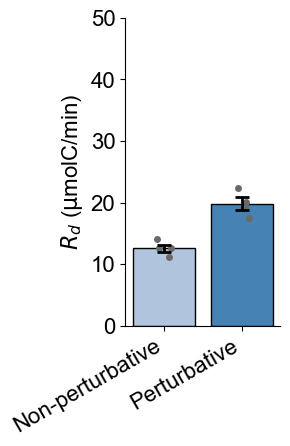

In [19]:
plot_rate_of_disappearance(df2, 'lactate', 'lactate', 3)

p-value non-perturbative vs perturbative: 9.10938894737464e-05


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3284299520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rate_of_disappearance'] = (1-df['value'])/df['value']*df['TRACER_UMOL_MIN'] + df['TRACER_UMOL_MIN']
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3284299520.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_perturbative.loc[:,'condition'] = 'Non-perturbative'
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3284299520.py:11: SettingWithC

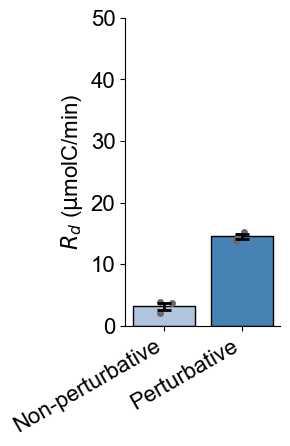

In [20]:
plot_rate_of_disappearance(df2, '3hb', '3-hydroxybutyrate', 4)

In [21]:
data = df[ (df.TIME >= 100) & (df.TIME <= 140) ] 
data['vco2_umol_min'.upper()] = data['vco2'.upper()].astype(float) * 1000/22.4

# Average over an hour per Day, cage and tracer
data = data.groupby(['DAY', 'CAGE','TRACER']).mean().reset_index()

# Take as 150 equivalent approximatly
data.TIME = 120

# Join in the labeling data
df2_temp = df2.drop(columns=['TRACER_UMOL_MIN'])
# Select rows 
glucose = df2_temp[(df2_temp.COMPOUND == 'Glucose') & (df2_temp.C_LABEL == 6) & (df2_temp.TRACER == 'glucose')]
lactate = df2_temp[(df2_temp.COMPOUND == 'lactate') & (df2_temp.C_LABEL == 3) & (df2_temp.TRACER == 'lactate')]
hb = df2_temp[(df2_temp.COMPOUND == '3-hydroxybutyrate') & (df2_temp.C_LABEL == 4) & (df2_temp.TRACER == '3hb')]

df2_temp = pd.concat([glucose, lactate, hb])

data = pd.merge(data, df2_temp, on=['CAGE', 'DAY', 'TRACER', 'TIME'], how='inner')
data.head()


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/3884474700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['vco2_umol_min'.upper()] = data['vco2'.upper()].astype(float) * 1000/22.4


,DAY,CAGE,TRACER,TIME,VCO2,SI13C,ENRICH,TRACER_UMOL_MIN,CO2_FLUX,RECOVERY,VCO2_UMOL_MIN,COMPOUND,C_LABEL,variable,value,COUNTS
0,non-perturbative,1,glucose,120,0.936033,2568.132024,0.027456,2.04120,1.145423,0.623502,41.787186,Glucose,6,DAY1_CAGE1_T120,0.135270,1449
1,non-perturbative,2,lactate,120,0.863435,2672.435098,0.028539,1.56240,1.092274,0.776778,38.546186,lactate,3,DAY1_CAGE2_T120,0.119549,1449
2,non-perturbative,3,3hb,120,0.906376,665.120620,0.007277,0.40160,0.292191,0.808409,40.463228,3-hydroxybutyrate,4,DAY1_CAGE3_T120,0.199621,1449
3,non-perturbative,4,glucose,120,0.947185,2444.938805,0.026172,2.17560,1.114337,0.569108,42.285056,Glucose,6,DAY1_CAGE4_T120,0.127457,1449
4,non-perturbative,5,lactate,120,0.978819,2743.674195,0.029277,1.81629,1.279034,0.782446,43.697256,lactate,3,DAY1_CAGE5_T120,0.121413,1449


In [22]:
# Plot VCO2 and ROX
VCO2 = data[['DAY','VCO2_UMOL_MIN','TRACER']].reset_index()
# 
data['Rd'] = (1-data['value'])/data['value']*data['TRACER_UMOL_MIN'] + data['TRACER_UMOL_MIN'] 
data['Ra'] = (1-data['value'])/data['value']*data['TRACER_UMOL_MIN'] + data['TRACER_UMOL_MIN'] 

# Birbonate recovery used from Toni preprint -> 0.9 ask Josh if we need that 
data['ROX'] = data['Rd'] * data['RECOVERY']  
data.head()

# # Glucose correction
# glucose = data[data['TRACER'] == 'glucose']
# glucose = glucose.merge(lac_from_glu, on=['CAGE', 'DAY', 'TIME'], how='inner')
# glucose['ROX'] = glucose['VCO2_UMOL_MIN'] * glucose['ENRICH'] / glucose['value_x'] * (1 - glucose['value_y'])
# # Lactate correction
# lactate = data[data['TRACER'] == 'lactate']
# lactate = lactate.merge(glu_from_lac, on=['CAGE', 'DAY', 'TIME'], how='inner')
# lactate['ROX'] = lactate['VCO2_UMOL_MIN'] * lactate['ENRICH'] / lactate['value_x'] * ( 1 - lactate['value_y'])  


# # Replace corrected ROX values in data
# data = pd.concat([glucose, lactate, data[data['TRACER'] == '3hb']])




,DAY,CAGE,TRACER,TIME,VCO2,SI13C,ENRICH,TRACER_UMOL_MIN,CO2_FLUX,RECOVERY,VCO2_UMOL_MIN,COMPOUND,C_LABEL,variable,value,COUNTS,Rd,Ra,ROX
0,non-perturbative,1,glucose,120,0.936033,2568.132024,0.027456,2.04120,1.145423,0.623502,41.787186,Glucose,6,DAY1_CAGE1_T120,0.135270,1449,15.089781,15.089781,9.408509
1,non-perturbative,2,lactate,120,0.863435,2672.435098,0.028539,1.56240,1.092274,0.776778,38.546186,lactate,3,DAY1_CAGE2_T120,0.119549,1449,13.069089,13.069089,10.151775
2,non-perturbative,3,3hb,120,0.906376,665.120620,0.007277,0.40160,0.292191,0.808409,40.463228,3-hydroxybutyrate,4,DAY1_CAGE3_T120,0.199621,1449,2.011817,2.011817,1.626372
3,non-perturbative,4,glucose,120,0.947185,2444.938805,0.026172,2.17560,1.114337,0.569108,42.285056,Glucose,6,DAY1_CAGE4_T120,0.127457,1449,17.069271,17.069271,9.714263
4,non-perturbative,5,lactate,120,0.978819,2743.674195,0.029277,1.81629,1.279034,0.782446,43.697256,lactate,3,DAY1_CAGE5_T120,0.121413,1449,14.959634,14.959634,11.705110


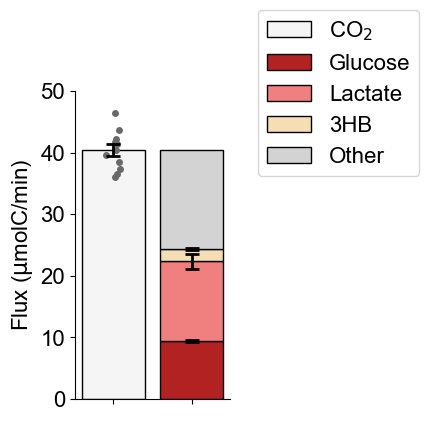

In [23]:
# Plot VCO2 and ROX (non-perturbative) as one bar plot + a stacked bar plot


plt.figure(figsize=(2.0, 4))

plt.bar(0, VCO2[VCO2['DAY'] == 'non-perturbative']['VCO2_UMOL_MIN'].mean(), color=colors_basal[0], label='CO${_2}$', edgecolor='black')
plt.errorbar(0, VCO2[VCO2['DAY'] == 'non-perturbative']['VCO2_UMOL_MIN'].mean(), 
             yerr=VCO2[VCO2['DAY'] == 'non-perturbative']['VCO2_UMOL_MIN'].sem(), color='black',
             **errorbar_kwargs)

# Plot data points on top of vo2 bar
sns.stripplot(x='DAY', y='VCO2_UMOL_MIN', 
              data=VCO2[VCO2['DAY'] == 'non-perturbative'], jitter=True, color='dimgrey', alpha=1.0, legend=False)

# Stack bars for ROX 
bottom = 0
temp_data = data[(data['DAY'] == 'non-perturbative') & (data['TRACER'] == 'glucose')]
plt.bar(1, temp_data['ROX'].mean(), color=colors_met[0], label='Glucose', edgecolor='black', bottom=bottom)
plt.errorbar(1, temp_data['ROX'].mean(), 
             yerr=temp_data['ROX'].sem(), color='black',
             **errorbar_kwargs)
bottom += temp_data['ROX'].mean()

temp_data = data[(data['DAY'] == 'non-perturbative') & (data['TRACER'] == 'lactate')]
plt.bar(1, temp_data['ROX'].mean(), color=colors_met[1], label='Lactate', edgecolor='black', bottom=bottom)
plt.errorbar(1, temp_data['ROX'].mean() + bottom, 
             yerr=temp_data['ROX'].sem(), color='black',
             **errorbar_kwargs)
bottom += temp_data['ROX'].mean()

temp_data = data[(data['DAY'] == 'non-perturbative') & (data['TRACER'] == '3hb')]
plt.bar(1, temp_data['ROX'].mean(), color=colors_met[2], label='3HB', edgecolor='black', bottom=bottom)
plt.errorbar(1, temp_data['ROX'].mean() + bottom, 
             yerr=temp_data['ROX'].sem(), color='black',
             **errorbar_kwargs)
bottom += temp_data['ROX'].mean()


other = VCO2[VCO2['DAY'] == 'non-perturbative']['VCO2_UMOL_MIN'].mean() - bottom
plt.bar(1, other, color='lightgrey', edgecolor='black', bottom=bottom, label='Other')


plt.xlabel('')
plt.ylabel('Flux ($\mathrm{\mu}$molC/min)')
plt.ylim([0, 50])   

# Plot ledgen out ise of plot upper right 
plt.legend(loc='upper center', bbox_to_anchor=(1.7, 1.3), ncol=1)
plt.xticks([0, 1], ['', ''], rotation=0,)
sns.despine()


plt.savefig('./output/CO2_flux_non-perturbative.svg')
plt.show()




In [40]:
# Plot CO2 flux for perturbative infusions

def plot_perturbative_oxidation(df,tracer,color, ylim=[0,60], folder='output'):
    df = df[(df['TRACER'] == tracer)]

    plt.figure(figsize=(3.0, 4))

    temp_data = df[df['DAY'] == 'non-perturbative']

    plt.bar(0, temp_data['VCO2_UMOL_MIN'].mean(), color=colors_basal[0], label='CO${_2}$', edgecolor='black')
    plt.errorbar(0, temp_data['VCO2_UMOL_MIN'].mean(), 
                 yerr=temp_data['VCO2_UMOL_MIN'].sem(), color='black',
                 **errorbar_kwargs)
    
    sns.stripplot(x=0, y='VCO2_UMOL_MIN',   
                  data=temp_data, jitter=True, color='dimgrey', alpha=1.0, legend=False)
    
    bottom = 0
    plt.bar(1, temp_data['ROX'].mean(), color=color, label='Glucose', edgecolor='black', bottom=bottom)
    plt.errorbar(1, temp_data['ROX'].mean(), 
                 yerr=temp_data['ROX'].sem(), color='black',
                 **errorbar_kwargs)
    bottom += temp_data['ROX'].mean()   
    other = temp_data['VCO2_UMOL_MIN'].mean() - temp_data['ROX'].mean()

    plt.bar(1, other, color='lightgrey', edgecolor='black', bottom=bottom, label='Other')


    sns.stripplot(x=1, y='ROX', data=temp_data, jitter=True, color='dimgrey', alpha=1.0, legend=False)


    # Perturbative
    temp_data = df[df['DAY'] == 'perturbative']

    plt.bar(2, temp_data['VCO2_UMOL_MIN'].mean(), color=colors_basal[0], edgecolor='black')
    plt.errorbar(2, temp_data['VCO2_UMOL_MIN'].mean(), 
                 yerr=temp_data['VCO2_UMOL_MIN'].sem(), color='black',
                 **errorbar_kwargs)
    
    sns.stripplot(x=2, y='VCO2_UMOL_MIN',
                    data=temp_data, jitter=True, color='dimgrey', alpha=1.0, legend=False)
    
    bottom = 0
    plt.bar(3, temp_data['ROX'].mean(), color=color, edgecolor='black', bottom=bottom)
    plt.errorbar(3, temp_data['ROX'].mean(), 
                 yerr=temp_data['ROX'].sem(), color='black',
                 **errorbar_kwargs)
    bottom += temp_data['ROX'].mean()

    sns.stripplot(x=3, y='ROX', data=temp_data, jitter=True, color='dimgrey', alpha=1.0, legend=False)
    
    plt.bar(3, other, color='lightgrey', edgecolor='black', bottom=bottom, label='Other')

    other_0 = temp_data['VCO2_UMOL_MIN'].mean() - temp_data['ROX'].mean()

    plt.bar(3, other-other_0, color='none', edgecolor='black', bottom=temp_data['VCO2_UMOL_MIN'].mean(), label='Excess', hatch="//")    

    
    plt.xlabel('')
    plt.ylabel('Flux ($\mathrm{\mu}$molC/min)')
    plt.xticks([0.5, 2.5], ['Non perturbative', 'Perturbative'], rotation=30, ha='right')

    plt.ylim(ylim)  
    sns.despine()

    plt.savefig(f'{folder}/CO2_flux_perturbative_{tracer}.pdf')
    plt.show()


In [41]:
data

,DAY,CAGE,TRACER,TIME,VCO2,SI13C,ENRICH,TRACER_UMOL_MIN,CO2_FLUX,RECOVERY,VCO2_UMOL_MIN,COMPOUND,C_LABEL,variable,value,COUNTS,Rd,Ra,ROX
0,non-perturbative,1,glucose,120,0.936033,2568.132024,0.027456,2.04120,1.145423,0.623502,41.787186,Glucose,6,DAY1_CAGE1_T120,0.135270,1449,15.089781,15.089781,9.408509
1,non-perturbative,2,lactate,120,0.863435,2672.435098,0.028539,1.56240,1.092274,0.776778,38.546186,lactate,3,DAY1_CAGE2_T120,0.119549,1449,13.069089,13.069089,10.151775
2,non-perturbative,3,3hb,120,0.906376,665.120620,0.007277,0.40160,0.292191,0.808409,40.463228,3-hydroxybutyrate,4,DAY1_CAGE3_T120,0.199621,1449,2.011817,2.011817,1.626372
3,non-perturbative,4,glucose,120,0.947185,2444.938805,0.026172,2.17560,1.114337,0.569108,42.285056,Glucose,6,DAY1_CAGE4_T120,0.127457,1449,17.069271,17.069271,9.714263
4,non-perturbative,5,lactate,120,0.978819,2743.674195,0.029277,1.81629,1.279034,0.782446,43.697256,lactate,3,DAY1_CAGE5_T120,0.121413,1449,14.959634,14.959634,11.705110
5,non-perturbative,6,3hb,120,0.926552,667.820920,0.007306,0.43200,0.301335,0.775038,41.363944,3-hydroxybutyrate,4,DAY1_CAGE6_T120,0.161503,1449,2.674877,2.674877,2.073131
6,non-perturbative,9,glucose,120,0.808400,4243.251439,0.044540,2.31840,1.611267,0.772212,36.089298,Glucose,6,DAY1_CAGE9_T120,0.196297,1449,11.810695,11.810695,9.120361
7,non-perturbative,10,lactate,120,1.038394,2478.040439,0.026522,1.66005,1.222621,0.818329,46.356855,lactate,3,DAY1_CAGE10_T120,0.092225,1449,18.000075,18.000075,14.729991
8,non-perturbative,11,3hb,120,0.819090,588.557244,0.006448,0.38720,0.235361,0.675393,36.566524,3-hydroxybutyrate,4,DAY1_CAGE11_T120,0.108681,1449,3.562729,3.562729,2.406244
9,non-perturbative,12,glucose,120,0.888184,2889.382610,0.030784,1.89000,1.219434,0.716893,39.651076,Glucose,6,DAY1_CAGE12_T120,0.141004,1449,13.403845,13.403845,9.609117


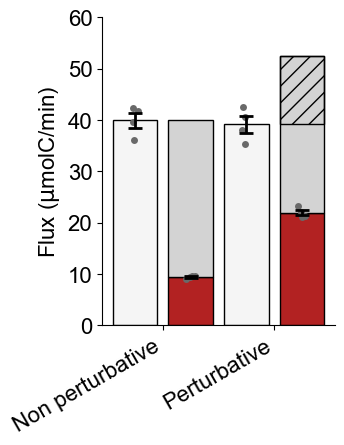

In [42]:
plot_perturbative_oxidation(data, 'glucose', colors_met[0])

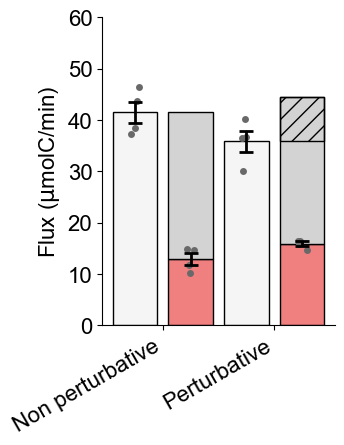

In [43]:
plot_perturbative_oxidation(data, 'lactate', colors_met[1])

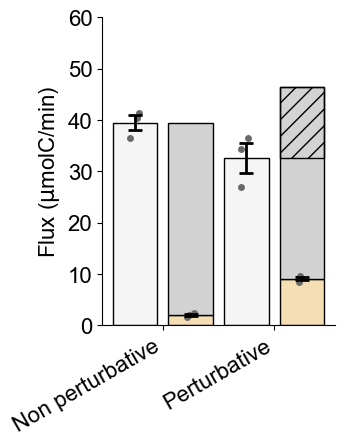

In [44]:
plot_perturbative_oxidation(data, '3hb', colors_met[2])

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/2005463651.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, fontfamily='Arial')
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_66805/2005463651.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, fontfamily='Arial')


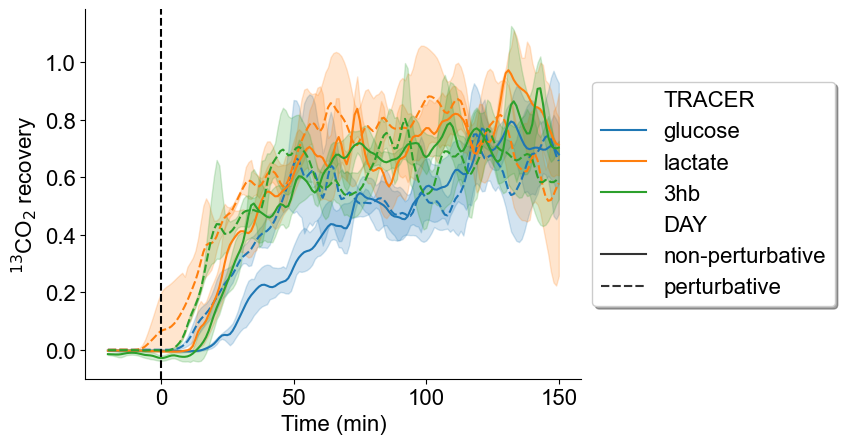

In [29]:
# Plot time series data
this_data = df[ (df.TIME >= -20) & (df.TIME <= 150) ] 
ax = sns.lineplot(data=this_data, x='TIME', y='RECOVERY', style='DAY', hue='TRACER')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, fontfamily='Arial')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, fontfamily='Arial')

ax.set_ylabel('$^{13}$CO$_2$ recovery', fontsize=16, fontfamily='Arial')
ax.set_xlabel('Time (min)', fontsize=16, fontfamily='Arial')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), 
          fontsize=16, title_fontsize=16, shadow=True)

# Put aline at x=0
plt.axvline(x=0, color='black', linestyle='--')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()